### To-do List
1) Try out regularizer,dropouts,etc.\
2) Try out learning rate scheduling e.g. start at 0.01 lr then after 2 epochs reduce to 0.0001 for lr\
3) Try out different batch sizes\
4) Try out different architecture if done everything to minimize loss in current arch. such as adding more layers,neurons,etc.\
5) If step 4 doesn't work anymore need to change model to say CNN or LSTM etc.\
6) Use common/well known model architectures first for example for CNN use ResNet,AlexNet,LeNet,etc.\
7) Start with small networks first for the common model architectures e.g AlexNet with 5-6 layers
8) 

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
import math
import csv
from glob import glob

"""Change to the data folder"""
train_path = "./new_train/new_train"
val_path = "./new_val_in/new_val_in"
# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)
            
        return data


# intialize a dataset
train_dataset = ArgoverseDataset(data_path=train_path)
val_dataset  = ArgoverseDataset(data_path=val_path)

### Create a loader to enable batch processing

In [3]:
batch_sz = 100

### train_collate definition for train_loader

In [4]:
def train_collate(batch): 
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    #print(batch[0]['car_mask'])
    agent_ids = [scene['agent_id'] for scene in batch]
    #agent_id = batch[0]['agent_id']
    car_masks = [scene['car_mask'] for scene in batch]
    #car_mask = batch[0]['car_mask']
    track_ids = [scene['track_id'] for scene in batch]
    
    #actual_objects = track_id[car_mask.reshape([-1]).astype(int)] #track id actually used
    actual_objects = []
    actual_obj = []
    agent_indices = []
    
    for c_mask,t_id in zip(car_masks,track_ids): #use only tracks that have vehicles on it, if no vehicle present it's labelled as -1
        for mask,track in zip(c_mask,t_id):
            if mask[0] == 1:
                actual_obj.append(track[0][0])
            else:
                actual_obj.append(-1)
        actual_objects.append(actual_obj)
        actual_obj = []
    
    for (i,track),agent_id in zip(enumerate(actual_objects),agent_ids): #will look through the tracks with vehicles and see which one is the agent's track
        for j,tr in enumerate(track):
    
            if tr == agent_id:
                agent_index = j
                break
        agent_indices.append(agent_index)
    
    inp = torch.LongTensor(inp)
    out = torch.LongTensor(out)
    scenes_indices = [scene['scene_idx'] for scene in batch]
    return [inp, out,scenes_indices,agent_indices]

### val_collate definition for val_loader

In [5]:
def val_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    inp = torch.LongTensor(inp)
    
    agent_ids = [scene['agent_id'] for scene in batch]
    car_masks = [scene['car_mask'] for scene in batch]
    track_ids = [scene['track_id'] for scene in batch]
    
    actual_objects = [] #track id actually used
    actual_obj = []
    agent_indices = []
    
    for c_mask,t_id in zip(car_masks,track_ids): #use only tracks that have vehicles on it, if no vehicle present it's labelled as -1
        for mask,track in zip(c_mask,t_id):
            if mask[0] == 1:
                actual_obj.append(track[0][0])
            else:
                actual_obj.append(-1)
        actual_objects.append(actual_obj)
        actual_obj = []
    
    for (i,track),agent_id in zip(enumerate(actual_objects),agent_ids): #will look through the tracks with vehicles and see which one is the agent's track
        for j,tr in enumerate(track):
            if tr == agent_id:
                agent_index = j
                break
        agent_indices.append(agent_index)
    
    inp = torch.LongTensor(inp)

    scenes_indices = [scene['scene_idx'] for scene in batch]
    return [inp, scenes_indices,agent_indices]

### Set train_loader and val_loader

In [6]:
train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = True, collate_fn=train_collate, num_workers=8)
val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=val_collate, num_workers=8)

### Fully Connected Network Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class RNN(nn.Module):
    
    def __init__(self, n_steps=5, n_hidden=100, n_layers=2,
                               drop_prob=0.2, lr=0.0001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        self.softMax = nn.LogSoftmax()
        #self.softMax = F.softmax()
        # creating character dictionaries
        #self.chars = tokens
        #self.int2char = dict(enumerate(self.chars))
        #self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        ## TODO: define the LSTM
        self.hidden_n = 400
        self.layers_n = 2
        self.lstm = nn.LSTM(19 * 4, n_hidden, num_layers=n_layers, 
                            batch_first=True)#dropout=drop_prob, batch_first=True)
        self.temperature = 1.5
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc1 = nn.Linear(n_hidden, 1000)
        self.fc2 = nn.Linear(1000,2000)
        self.fc3 = nn.Linear(2000,3000)
        self.fc4 = nn.Linear(3000,30 * 4)
        # initialize the weights
        self.init_weights()
      
    
    def forward(self, x):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hc`. '''
        ## TODO: Get x, and the new hidden state (h, c) from the lstm
        x,_ = self.lstm(x)
        
        ## TODO: pass x through a droupout layer
        x = self.dropout(x)
        
        # Stack up LSTM outputs using view
        x = x.reshape(x.size()[0]*x.size()[1], self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        #x = self.softMax(x/self.temperature, dim=1)
        #x = F.softmax(x/self.temperature)
        # return x and the hidden state (h, c)
        return x/self.temperature
    
    def predict(self, char, h=None, cuda=False, top_k=None):
        ''' Given a character, predict the next character.
        
            Returns the predicted character and the hidden state.
        '''
        if cuda:
            self.cuda()
        else:
            self.cpu()
        
        if h is None:
            h = self.init_hidden(1)
            
        #print(self.char2int);
        x = np.array([[self.char2int[char]]])
        x = one_hot_encode(x, len(self.chars))
        inputs = torch.from_numpy(x)
        if cuda:
            inputs = inputs.cuda()
        
        h = tuple([each.data for each in h])
        out, h = self.forward(inputs, h)

        p = F.softmax(out, dim=1).data
        if cuda:
            p = p.cpu()
        
        if top_k is None:
            top_ch = np.arange(len(self.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
            
        return self.int2char[char], h
    
    def init_weights(self):
        ''' Initialize weights for fully connected layer '''
        initrange = 0.1
        
        # Set bias tensor to all zeros
        self.fc1.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc1.weight.data.uniform_(-1, 1)
        
        # Set bias tensor to all zeros
        self.fc2.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc2.weight.data.uniform_(-1, 1)
        
        # Set bias tensor to all zeros
        self.fc3.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc3.weight.data.uniform_(-1, 1)
        
        # Set bias tensor to all zeros
        self.fc4.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc4.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, n_seqs, self.n_hidden).zero_(),
                weight.new(self.n_layers, n_seqs, self.n_hidden).zero_())

### define Train function

In [8]:
from tqdm.notebook import tqdm
def train(model, device, train_batch, optimizer, epoch,log_interval=10000):
    model.train()
    #iterator = tqdm(train_batch, total=int(len(train_batch)))
    #counter = 0
    
    data,target,scenes_indices,agent_indices = train_batch
    #data = data.to(device)
    
    optimizer.zero_grad()
    #print(len(train_batch))
    data = data.type(torch.FloatTensor)
    data = torch.reshape(data,(len(data),60, 19 * 4))
    data = data.to(device)
    #print(len(data)
    
    
    target = target.type(torch.FloatTensor)
    output = model(data)
    
    #target = torch.reshape(target,(len(data),60, 30 * 4)) 
    
    '''
    output = batch_size x (60 * 30 * 4)
    
    '''

   

    output = torch.reshape(output,(len(data),60 * 30 * 4))
    target = torch.reshape(target,(len(data),60 * 30 * 4))
    target = target.to(device)
    output = output.to(device)
    
#   outputPickleFormat = torch.reshape(output,(len(data),60,30,4))
#   targetPickleFormat = torch.reshape(target,(len(data),60,30,4))
#   targetPickleFormat = targetPickleFormat.to(device)
#   outputPickleFormat = outputPickleFormat.to(device)
    
    loss = torch.mean((target - output)**2)**0.5
    #print(loss)
#     loss.backward()
    
    
#     loss = 0
    
#     for i,scene in enumerate(targetPickleFormat):
#         for j,vehicle in enumerate(scene):
#             for k,value in enumerate(vehicle[29]):
#                 loss += torch.mean((value - outputPickleFormat[i][j][29][k])**2)**0.5
                
    loss.backward()
    
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), 1000000000)
    optimizer.step()
    
   
    return loss.item()
    #counter += 1
    #torch.cuda.empty_cache()
    #iterator.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))
    #histogram for x and y input positions of train's agents
    

### define Test function

In [9]:
def test(model, device, test_batch):#target_loader,epoch):
    model.eval()
    test_loss = 0
    predictedPos = []
    predPosArr = []
    correct = 0
    
    with torch.no_grad():
        data,scenes_indices,agent_indices = test_batch
        data = data.type(torch.FloatTensor)
        data = torch.reshape(data,(len(data),60,19 * 4))
        data = data.to(device)
        output = model(data)
        #output = torch.reshape(output,(len(data),60 * 30 * 4))
        outputPickleFormat = torch.reshape(output,(len(data),60,30,4))
        outputPickleFormat = outputPickleFormat.to(device)
        
        #Get target agent's pos x and pos y to put into csv for submission later on
        agent_batch_out = []
        agent_predicted_vals = []
        for scene_out,agent_idx,scene_idx in zip(outputPickleFormat,agent_indices,scenes_indices):
            for time_step in scene_out[agent_idx]:
                agent_predicted_vals.append(time_step[0].item())
                agent_predicted_vals.append(time_step[1].item())
            agent_predicted_vals.insert(0,scene_idx)
            agent_batch_out.append(agent_predicted_vals)
            agent_predicted_vals = []

    return agent_batch_out
    

### Write CSV header

In [10]:
import matplotlib.pyplot as plt
import random

with open('submissionLSTM.csv','w',newline='') as f:
    thewriter = csv.writer(f)
    headerRow = []
    
    headerRow.append("ID")
    for i in range(1,61):
        headerRow.append("v" + str(i))
        
    thewriter.writerow(headerRow)

### show_sample_batch function definition

In [11]:
agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out,scenes_indices = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

### Definition of histogram plots for input and output for training

In [12]:
def plotTrainInOutPos(inp_posx_arr,inp_posy_arr,out_posx_arr,out_posy_arr,out_vel_arr,out_vel_target_arr,bins_cnt):
    plt.style.use('fivethirtyeight')
    plt.hist(inp_posx_arr,bins=bins_cnt,edgecolor='black',log='true')
    plt.title("Input x-axis distribution for all agents in training")
    plt.xlabel("x-position")
    plt.ylabel("frequency")
    plt.show()

    plt.style.use('fivethirtyeight')
    plt.hist(inp_posy_arr,bins=bins_cnt,edgecolor='black',log='true')
    plt.title("Input y-axis distribution for all agents in training")
    plt.xlabel("y-position")
    plt.ylabel("frequency")
    plt.show()

    #histogram for x and y output positions of train's agents
    plt.style.use('fivethirtyeight')
    plt.hist(out_posx_arr,bins=bins_cnt,edgecolor='black',log='true')
    plt.title("Output x-axis distribution for all agents in training")
    plt.xlabel("x-position")
    plt.ylabel("frequency")
    plt.show()

    plt.style.use('fivethirtyeight')
    plt.hist(out_posy_arr,bins=bins_cnt,edgecolor='black',log='true')
    plt.title("Output y-axis distribution for all agents in training")
    plt.xlabel("y-position")
    plt.ylabel("frequency")
    plt.show()
    
    plt.style.use('fivethirtyeight')
    plt.hist(out_vel_arr,bins=bins_cnt,edgecolor='black',log='true')
    plt.title("Velocity out magnitudes distribution")
    plt.xlabel("Velocity Magnitudes")
    plt.ylabel("frequency")
    plt.show()
    
    plt.style.use('fivethirtyeight')
    plt.hist(out_vel_target_arr,bins=bins_cnt,edgecolor='black',log='true')
    plt.title("Velocity out magnitudes distribution for target agents")
    plt.xlabel("Velocity Magnitudes")
    plt.ylabel("frequency")
    plt.show()

In [13]:
def plotLoss(loss_arr,epoch):
    plt.style.use('fivethirtyeight')
    plt.plot(loss_arr,'r')
    plt.title("Loss graph after epoch " + str(epoch))
    plt.xlabel("indices")
    plt.ylabel("loss")
    plt.show()

### Start training (main)

cuda chosen
Number of batches to iterate through for training dataset:  2060
Batch size:  100


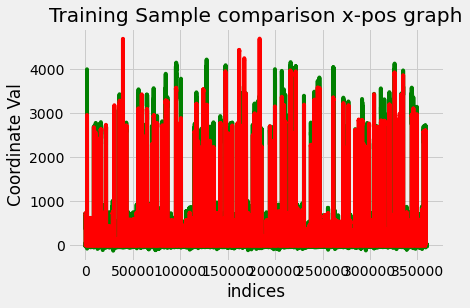

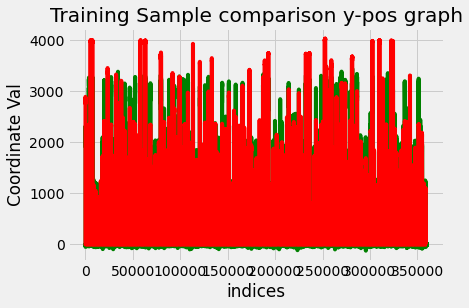

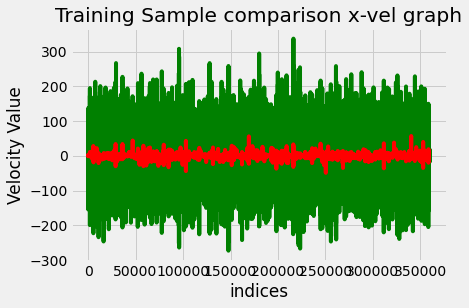

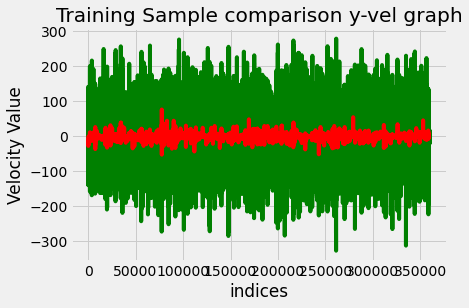

Done with training on epoch  1


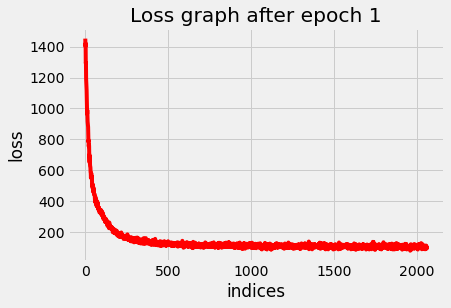


Done with training on epoch  2


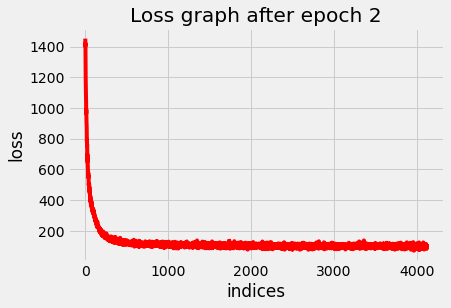


Done with training on epoch  3


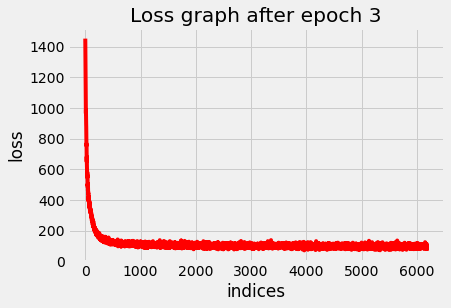


Done with training on epoch  4


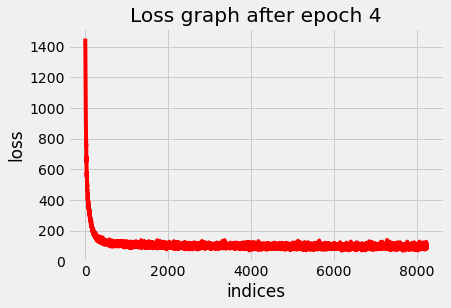


Done with training on epoch  5


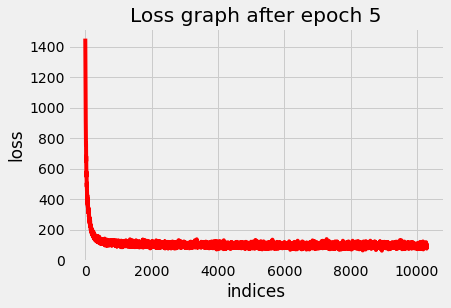

TypeError: test() takes 3 positional arguments but 4 were given

In [14]:
learning_rate = 1e-4

if torch.cuda.is_available():
    print("cuda chosen")
    dev = "cuda"
else:
    print("cpu chosen")
    dev = "cpu"
        
device = dev
model = RNN().cuda() #using cpu here
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epoch = 5


inp_posx_hist = []
inp_posy_hist = []
out_posx_hist = []
out_posy_hist = []
out_vel_hist = []
out_vel_target_hist = []

training_samples_target_posx = []
training_samples_target_posy = []
training_samples_target_velx = []
training_samples_target_vely = []
training_samples_pred_in =  []
training_samples_pred_out_posx = []
training_samples_pred_out_posy = []
training_samples_pred_out_velx = []
training_samples_pred_out_vely = []
loss_arr = []

print("Number of batches to iterate through for training dataset: ",len(train_loader))
print("Batch size: ",batch_sz)
for epoch in range(1, num_epoch + 1):
    iterator_train = tqdm(train_loader, total=int(len(train_loader)))
    
    for i_batch, train_batch in enumerate(iterator_train): #Begin training 
        if epoch == 1:
            inp_train, out_train, scenes_indices_train,agent_indices_train = train_batch
        
            if(i_batch < 2):
                for scene_in,scene_out in zip(inp_train,out_train):
                    scene_out = scene_out.type(torch.FloatTensor)
                    for vehicles in scene_out:
                        for time_step in vehicles:
                            training_samples_target_posx.append(time_step[0].item())
                            training_samples_target_posy.append(time_step[1].item())
                            training_samples_target_velx.append(time_step[2].item())
                            training_samples_target_vely.append(time_step[3].item())
                    
                    scene_in = scene_in.type(torch.FloatTensor)
                    training_samples_pred_in.append(scene_in)
                
        add_loss = train(model, device, train_batch, optimizer, epoch) #replace train_loader with our input training data
        loss_arr.append(add_loss)
        iterator_train.set_postfix(loss=add_loss)
    
    

    
    if epoch == 1:
        for sample_pred_in in training_samples_pred_in:
            sample_pred_in = torch.reshape(sample_pred_in,(1,60,19*4)) #need to reshape to this for our model
            sample_pred_in = sample_pred_in.type(torch.FloatTensor)
            sample_pred_in = sample_pred_in.to(device)
            sample_pred_out = model(sample_pred_in) #will have size 1x (60*30*4)
            sample_pred_out = torch.reshape(sample_pred_out,(1,60,30,4))
            for vehicle in sample_pred_out[0]:
                for time_step in vehicle:
                    training_samples_pred_out_posx.append(time_step[0].item())
                    training_samples_pred_out_posy.append(time_step[1].item())
                    training_samples_pred_out_velx.append(time_step[2].item())
                    training_samples_pred_out_vely.append(time_step[3].item())
        
        #t = numpy.linspace(0, len(training_samples_pred_out_posx), endpoint=True)
        plt.style.use('fivethirtyeight')
        plt.plot(training_samples_pred_out_posx,'g',label='Predicted output')
        plt.plot(training_samples_target_posx,'r',label='Ground truth output')
        plt.title("Training Sample comparison x-pos graph")
        plt.xlabel("indices")
        plt.ylabel("Coordinate Val")
        plt.show()

        #s = numpy.linspace(0, len(train_samples_pred_out_posx), endpoint=True)
        plt.style.use('fivethirtyeight')
        plt.plot(training_samples_pred_out_posy,'g',label='Predicted output')
        plt.plot(training_samples_target_posy,'r',label='Ground truth output')
        plt.title("Training Sample comparison y-pos graph")
        plt.xlabel("indices")
        plt.ylabel("Coordinate Val")
        plt.show()

        #v = numpy.linspace(0, len(train_samples_pred_out_posx), endpoint=True)
        plt.style.use('fivethirtyeight')
        plt.plot(training_samples_pred_out_velx,'g',label='Predicted output')
        plt.plot(training_samples_target_velx,'r',label='Ground truth output')
        plt.title("Training Sample comparison x-vel graph")
        plt.xlabel("indices")
        plt.ylabel("Velocity Value")
        plt.show()

        #w = numpy.linspace(0, len(train_samples_pred_out_posx), endpoint=True)
        plt.style.use('fivethirtyeight')
        plt.plot(training_samples_pred_out_vely,'g',label='Predicted output')
        plt.plot(training_samples_target_vely,'r',label='Ground truth output')
        plt.title("Training Sample comparison y-vel graph")
        plt.xlabel("indices")
        plt.ylabel("Velocity Value")
        plt.show()
    
    print("Done with training on epoch ",epoch)
    plotLoss(loss_arr,epoch)
    
    
#Begin testing
iterator_test = tqdm(val_loader,total=int(len(val_loader)))
for i_batch,test_batch in enumerate(iterator_test):
    predicted_batches = test(model, device, test_batch,epoch)

    if epoch == num_epoch: #if done with the last epoch then we write to file
        with open('submissionLSTM.csv','a',newline='') as f: #append to csv
            thewriter = csv.writer(f)
            for p_list in predicted_batches:
                thewriter.writerow(p_list)